# 🌍 Day 5: Document Translation with Transformers

Welcome to Day 5 of the Generative AI workshop!

Today we'll focus on **machine translation** — the task of automatically converting text from one language to another using transformer models. This is one of the most impactful applications of modern NLP.

We'll walk through a practical pipeline:
- Upload a PDF file in English
- Extract and chunk the text
- Use a pre-trained multilingual model to translate it (e.g., to Arabic)
- View translated output for each chunk and compare results

By the end of this session, you'll be able to build a simple document translator using open-source tools.


## 🔧 Install Required Packages

## What We'll Install:

- **`PyPDF2`** - For extracting text from PDF documents
- **`transformers`** - Hugging Face library for loading pre-trained translation models
- **`tqdm`** - Creates progress bars to track translation progress
- **`nltk`** - Natural Language Toolkit for text processing and BLEU score calculation
- **`matplotlib`** - For creating visualizations of our results

In [ ]:
!pip install PyPDF2 transformers tqdm nltk --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 232.6/232.6 kB 4.1 MB/s eta 0:00:00


Now we'll import all the libraries we need for our machine translation pipeline. Each import serves a specific role in our workflow.

## Core Libraries Explained:

- **`PdfReader`** - Extracts text from PDF files (we'll use a test story instead)
- **`AutoTokenizer`** - Converts text into tokens that neural networks can understand
- **`AutoModelForSeq2SeqLM`** - Loads pre-trained sequence-to-sequence translation models
- **`tqdm`** - Displays progress bars during translation processes
- **`torch`** - PyTorch framework that powers our neural translation models

In [ ]:
from PyPDF2 import PdfReader
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM
from tqdm import tqdm
import torch

# 🌐 Load Translation Model

We'll use a pre-trained model from Hugging Face to translate English to Arabic.

**Model**: `Helsinki-NLP/opus-mt-en-ar`
- **Helsinki-NLP**: Research group specializing in machine translation
- **opus-mt**: OPUS Machine Translation project with 1000+ language pairs
- **en-ar**: English → Arabic translation direction

This model was trained on millions of parallel English-Arabic sentence pairs and can handle various text types, though it struggles with idioms and cultural expressions.

In [ ]:
# Load pre-trained English → Arabic translation model
tokenizer = AutoTokenizer.from_pretrained("Helsinki-NLP/opus-mt-en-ar")
model = AutoModelForSeq2SeqLM.from_pretrained("Helsinki-NLP/opus-mt-en-ar")

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/44.0 [00:00<?, ?B/s]

config.json: 0.00B [00:00, ?B/s]

source.spm:   0%|          | 0.00/801k [00:00<?, ?B/s]

target.spm:   0%|          | 0.00/917k [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

/usr/local/lib/python3.11/dist-packages/transformers/models/marian/tokenization_marian.py:175: UserWarning: Recommended: pip install sacremoses.
  warnings.warn("Recommended: pip install sacremoses.")


pytorch_model.bin:   0%|          | 0.00/308M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/308M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/293 [00:00<?, ?B/s]

# 📖 Load Test Story with Translation Challenges

We'll translate a story containing challenging elements that will test our machine translation system:

- **Idioms** (break a leg, piece of cake) - Often translate literally instead of meaningfully
- **Numbers and dates** (March 15th, 2024, $95,750) - Formatting and cultural conventions
- **Proper names** (Sarah Johnson, Robert Chen III) - Should remain unchanged
- **Technical terms and percentages** - Domain-specific vocabulary challenges

This story will help us understand both the **strengths** and **limitations** of modern machine translation.

In [ ]:
# Simple test story with token counting
test_story = """On March 15th, 2024, Sarah Johnson received an email that would change her life forever. The subject line read: "Congratulations! You've been selected for TechVenture Accelerator 2024."

Sarah couldn't believe her eyes. After 3.5 years of working as a software engineer at DataCorp Inc., earning $95,750 annually, she was finally getting her shot at the big leagues. Her startup idea, "SmartHome AI," had caught the attention of investors.

"Break a leg at the presentation!" texted her best friend Mike at 9:30 AM.

The accelerator program was no joke. Sarah had to pitch to 50+ investors, including billionaire tech mogul Robert Chen III, who was known for being tougher than nails. The stakes were high: $2.5 million in seed funding was on the line.

Sarah's presentation went like this: "Ladies and gentlemen, imagine a world where your home knows you better than you know yourself. Our AI can predict when you'll arrive home with 97.3% accuracy, adjust the temperature to exactly 72.5°F, and even order groceries before you run out."

The room was dead silent. Then Robert Chen stood up. "That's a piece of cake for any decent ML engineer," he said. "What makes you different?"

Sarah's heart sank. She felt like she was between a rock and a hard place. But then she remembered her secret weapon.

"Mr. Chen," she said, "our AI doesn't just learn patterns. It understands context. When my grandmother, who's 84 years old, visits every Sunday at 2:00 PM, the system knows to prepare her favorite chamomile tea and lower the music volume. It's not just smart - it's thoughtful."

Robert's expression softened. "Now you're cooking with gas," he said. "Tell me more."
"""

# Count tokens using the tokenizer
tokens = tokenizer.encode(test_story)
num_tokens = len(tokens)

print(f"Test story loaded: {len(test_story)} characters")
print(f"Number of tokens: {num_tokens}")
print(f"Average characters per token: {len(test_story)/num_tokens:.1f}")

Test story loaded: 1669 characters
Number of tokens: 405
Average characters per token: 4.1


# ✂️ Chunk the Text

Translation models work best with short segments. We'll break the document into smaller sentence-based chunks.

**Why sentence-level chunking?**
- **Better quality**: Each sentence gets focused translation attention
- **Easier evaluation**: Compare translations sentence by sentence
- **No cutoffs**: Complete thoughts translate more accurately than partial ones
- **Educational value**: We can see exactly where translation succeeds or fails

In [ ]:
# Simple sentence-based chunking for better translation quality
import re

def split_by_sentences(text):
    # Split on sentence endings, keep the punctuation
    sentences = re.split(r'(?<=[.!?])\s+', text.strip())
    # Return only non-empty sentences
    return [s.strip() for s in sentences if s.strip()]

# Create sentence-level chunks instead of arbitrary length chunks
sentence_chunks = split_by_sentences(test_story)

print(f"Created {len(sentence_chunks)} sentences")
# Preview first 5 sentences to see our chunking results
for i, sentence in enumerate(sentence_chunks[:5]):
    print(f"Sentence {i+1}: {sentence}")
    print()

Created 23 sentences
Sentence 1: On March 15th, 2024, Sarah Johnson received an email that would change her life forever.

Sentence 2: The subject line read: "Congratulations!

Sentence 3: You've been selected for TechVenture Accelerator 2024."

Sarah couldn't believe her eyes.

Sentence 4: After 3.5 years of working as a software engineer at DataCorp Inc., earning $95,750 annually, she was finally getting her shot at the big leagues.

Sentence 5: Her startup idea, "SmartHome AI," had caught the attention of investors.



### 🧠 Define Translation Function

This function will translate an **English sentence into Arabic** using a pre-trained transformer model (such as `MarianMT`, `M2M100`, or similar).

---

#### 🔍 Function Description:

The `translate` function performs the following steps:

1. **Tokenizes** the input English text using the model's tokenizer.
2. **Generates** an Arabic translation using the `generate()` method.
3. **Decodes** the model output token IDs into human-readable Arabic text.

---

#### 🛠️ Generation Parameters Explained:

- `max_new_tokens=300`: Limits the number of tokens to generate.
- `num_beams=5`: Uses beam search with 5 beams to enhance translation quality.
- `do_sample=True`: Enables sampling instead of greedy decoding.
- `top_k=50`: Limits sampling to the top 50 token options at each step.
- `top_p=0.95`: Applies nucleus sampling (only sample from the smallest set whose cumulative probability ≥ 0.95).
- `temperature=0.8`: Controls randomness in predictions (lower is more conservative).
- `early_stopping=True`: Stops generation when the best output is likely reached.

These parameters can be tuned for a balance between **translation accuracy** and **generation diversity**.


In [ ]:
def translate(text):
    # Tokenize the input English sentence
    inputs = tokenizer(
        text,
        return_tensors="pt",
        truncation=True,
        padding=True,
        max_length=512
    )

    # Generate Arabic translation with advanced decoding strategies
    outputs = model.generate(
        **inputs,
        max_new_tokens=300,      # Limit on new tokens to generate
        num_beams=5,             # Beam search with 5 beams for better translation
        do_sample=True,          # Enable sampling (useful for diversity)
        top_k=50,                # Top-k sampling
        top_p=0.95,              # Nucleus sampling
        temperature=0.8,         # Lower temp = more deterministic output
        early_stopping=True      # Stop early when best translation is likely found
    )

    # Decode output token IDs into Arabic text
    return tokenizer.decode(outputs[0], skip_special_tokens=True)


### 🔄 Translate All Chunks

We’ll translate each **text chunk** (from English to Arabic) and collect the results in a list.

This is useful when working with large inputs that have been pre-split into smaller segments (e.g., paragraphs, sentences, or token chunks). Each chunk will be translated individually, and a progress bar will show the translation progress using `tqdm`.

---

#### 🧠 Why Chunking?

Translation models often have a token limit (e.g., 512 tokens), so chunking helps:
- Avoid truncation or cutoff.
- Improve translation quality.
- Enable batch processing and progress tracking.

In [ ]:
# Translate each chunk and show progress bar
translations = [translate(chunk) for chunk in tqdm(sentence_chunks, desc="Translating chunks")]


Translating chunks: 100%|██████████| 23/23 [00:35<00:00,  1.54s/it]


### 📄 Translated Document (Arabic)

Let’s view the translated version of the full document. This cell prints each original English chunk alongside its Arabic translation in a readable format.

---

#### 📝 What This Does:

- Neatly formats the output for each translated chunk.
- Labels each section to show which chunk is being printed.
- Helps with debugging or manual inspection of translations.
- Shows both original and translated texts for easy comparison.

---

#### 📌 Example Output:

```
==================================================
TRANSLATION RESULTS
==================================================

--- Chunk 1 ---
Original: This is an example.
Arabic: هذا مثال.
------------------------------
```


In [ ]:
# Print formatted translation results for the full document
print("\n" + "="*50)
print("TRANSLATION RESULTS")
print("="*50)

for i, (original, translation) in enumerate(zip(sentence_chunks, translations)):
    print(f"\n--- Chunk {i+1} ---")
    print(f"Original: {original}")
    print(f"Arabic: {translation}")
    print("-" * 30)



TRANSLATION RESULTS

--- Chunk 1 ---
Original: On March 15th, 2024, Sarah Johnson received an email that would change her life forever.
Arabic: في 15 مارس 2024، تلقت سارة جونسون رسالة إلكترونية من شأنها أن تغير حياتها إلى الأبد.
------------------------------

--- Chunk 2 ---
Original: The subject line read: "Congratulations!
Arabic: وفيما يلي نص الموضوع: "تهانينا!
------------------------------

--- Chunk 3 ---
Original: You've been selected for TechVenture Accelerator 2024."

Sarah couldn't believe her eyes.
Arabic: تم اختيارك لتقنية "التكنلوجيا" Acelerator 2024 "سارة" لم تصدق عينيها
------------------------------

--- Chunk 4 ---
Original: After 3.5 years of working as a software engineer at DataCorp Inc., earning $95,750 annually, she was finally getting her shot at the big leagues.
Arabic: بعد 3.5 سنوات من العمل كمهندس برامج في شركة DataCorp Inc.، كسبت 95.5 750 دولار سنويا،
------------------------------

--- Chunk 5 ---
Original: Her startup idea, "SmartHome AI," had caught the 

### ✏️ BLEU Score Evaluation

To measure the quality of our translations, we'll use the **BLEU score** (Bilingual Evaluation Understudy).

---

#### 🔍 What is BLEU?

- **BLEU** compares the machine-generated translation with a human reference.
- It evaluates the **precision of n-gram overlaps** between the two texts.
- **Higher BLEU scores** (closer to 1.0) mean a closer match to the reference translation.
- BLEU is widely used for evaluating translation tasks in NLP.

---

#### 📌 Key Points:

- A perfect translation gets a BLEU score of 1.0.
- A poor translation may get a score closer to 0.
- BLEU is **case-sensitive** and often needs **smoothing** for short sentences.

---

We'll use **NLTK**'s `sentence_bleu()` method and apply a smoothing function to avoid zero scores on short sentences.


In [ ]:
# Import BLEU score tools from NLTK
import nltk
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction

# Download required tokenizer data for NLTK (used internally by some BLEU functions)
nltk.download("punkt")


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

### 📖 Reference Arabic Translations

Here we define **reference translations** for the first few English chunks.  
These are **human-curated** Arabic translations that serve as the **ground truth** when evaluating translation quality using BLEU or other metrics.

---

#### 📝 Why Are References Needed?

- BLEU score works by comparing model-generated output with a human reference.
- Accurate reference translations help measure how close the machine translation is to native-quality output.
- These references usually come from professional translators or trusted bilingual speakers.

---

#### ✅ Notes:
- Ensure each reference matches the corresponding English chunk in order.
- The structure should be a list of Arabic strings (`sentence_references`), aligned index-wise with your `sentence_chunks`.


In [ ]:
sentence_references = [
   # 1
   'في 15 مارس 2024، تلقت سارة جونسون رسالة بريد إلكتروني من شأنها أن تغير حياتها إلى الأبد.',

   # 2
   'كان عنوان الرسالة يقول: "تهانينا!',

   # 3
   'لقد تم اختيارك لبرنامج TechVenture Accelerator 2024." لم تصدق سارة عينيها.',

   # 4
   'بعد 3.5 سنوات من العمل كمهندسة برمجيات في شركة DataCorp Inc.، وكسب 95,750 دولار سنوياً، كانت تحصل أخيراً على فرصتها في الدوري الكبير.',

   # 5
   'فكرة شركتها الناشئة "SmartHome AI" قد جذبت انتباه المستثمرين.',

   # 6
   'أرسل لها أفضل أصدقائها مايك رسالة نصية في الساعة 9:30 صباحاً قائلاً: "حظاً موفقاً في العرض التقديمي!"',

   # 7
   'لم يكن برنامج المسرّع مزحة.',

   # 8
   'كان على سارة أن تقدم عرضها أمام أكثر من 50 مستثمر، بما في ذلك المليardير في مجال التكنولوجيا روبرت تشن الثالث، الذي كان معروفاً بصرامته الشديدة.',

   # 9
   'كانت المخاطر عالية: 2.5 مليون دولار من التمويل الأولي كان على المحك.',

   # 10
   'جاء عرض سارة التقديمي كما يلي: "سيداتي وسادتي، تخيلوا عالماً حيث منزلكم يعرفكم أفضل مما تعرفون أنفسكم.',

   # 11
   'ذكاؤنا الاصطناعي يمكنه التنبؤ بموعد وصولكم للمنزل بدقة 97.3%، وضبط درجة الحرارة إلى 72.5 فهرنهايت بالضبط، وحتى طلب البقالة قبل نفادها." ساد الصمت التام في القاعة.',

   # 12
   'ثم وقف روبرت تشن.',

   # 13
   'قال: "هذا أمر سهل جداً لأي مهندس تعلم آلي محترم."',

   # 14
   '"ما الذي يجعلك مختلفة؟" انقبض قلب سارة.',

   # 15
   'شعرت وكأنها في موقف صعب للغاية.',

   # 16
   'لكنها تذكرت سلاحها السري.',

   # 17
   '"سيد',

   # 18
   'تشن،" قالت، "ذكاؤنا الاصطناعي لا يتعلم الأنماط فحسب.',

   # 19
   'إنه يفهم السياق.',

   # 20
   'عندما تزورني جدتي، البالغة من العمر 84 عاماً، كل يوم أحد في الساعة 2:00 مساءً، يعرف النظام أن يحضر لها شاي البابونج المفضل ويخفض مستوى الموسيقى.',

   # 21
   'إنه ليس ذكياً فحسب - بل مراعٍ أيضاً." تلين تعبير روبرت.',

   # 22
   'قال: "الآن أنت تتقدمين بشكل ممتاز."',

   # 23
   '"أخبريني المزيد."'
]

### 🧮 BLEU Score Results

We'll now compute the **BLEU score** for each translation chunk and display the **average BLEU score** for all chunks.

---

#### 🔢 How This Works:

- This compares each **model-generated translation** to its **human reference** using `sentence_bleu()` from NLTK.
- BLEU is calculated per chunk, and then the **average BLEU score** is printed.

---

#### 🧪 Key Implementation Details:

- `SmoothingFunction().method4`: Used to avoid BLEU = 0 on short or partial outputs by applying smoothing.
- `.split()`: Tokenizes both reference and hypothesis sentences by whitespace.
- `min(...)`: Ensures we only compare as many pairs as exist in both reference and translation lists.
- `bleu_scores`: A list to store all individual scores.
- The final average is calculated and printed with 4 decimal points.

---

#### 📌 Output Example:

```
Chunk 1 BLEU score: 0.6231
Chunk 2 BLEU score: 0.5512
Chunk 3 BLEU score: 0.7310

◆ Average BLEU score: 0.6351
```


In [ ]:
# Use smoothing method to handle short sentences
smoother = SmoothingFunction().method4
bleu_scores = []

# Compare only available chunks in both lists
num_to_compare = min(len(translations), len(sentence_references))

print(f"Calculating BLEU scores for {num_to_compare} chunks...")

for i in range(num_to_compare):
    # Tokenize both reference and translation sentences
    reference_tokens = [sentence_references[i].split()]
    hypothesis_tokens = translations[i].split()

    # Calculate BLEU score with smoothing
    score = sentence_bleu(reference_tokens, hypothesis_tokens, smoothing_function=smoother)
    bleu_scores.append(score)

    print(f"Chunk {i+1} BLEU score: {score:.4f}")

# Display average BLEU score
if bleu_scores:
    avg_bleu = sum(bleu_scores) / len(bleu_scores)
    print(f"\n◆ Average BLEU score: {avg_bleu:.4f}")
else:
    print("No BLEU scores calculated")


Calculating BLEU scores for 23 chunks...
Chunk 1 BLEU score: 0.7660
Chunk 2 BLEU score: 0.0456
Chunk 3 BLEU score: 0.0729
Chunk 4 BLEU score: 0.2542
Chunk 5 BLEU score: 0.0989
Chunk 6 BLEU score: 0.0174
Chunk 7 BLEU score: 0.1341
Chunk 8 BLEU score: 0.1090
Chunk 9 BLEU score: 0.1281
Chunk 10 BLEU score: 0.3876
Chunk 11 BLEU score: 0.1162
Chunk 12 BLEU score: 0.1682
Chunk 13 BLEU score: 0.0626
Chunk 14 BLEU score: 0.4347
Chunk 15 BLEU score: 0.0819
Chunk 16 BLEU score: 0.1682
Chunk 17 BLEU score: 0.0000
Chunk 18 BLEU score: 0.0334
Chunk 19 BLEU score: 0.2118
Chunk 20 BLEU score: 0.0751
Chunk 21 BLEU score: 0.0259
Chunk 22 BLEU score: 0.0819
Chunk 23 BLEU score: 0.0675

◆ Average BLEU score: 0.1540


### 📊 BLEU Score Visualization

This cell visualizes the BLEU scores computed for each translated chunk using a bar plot.

---

#### 🎯 Why Visualize?

- Makes it easy to **compare translation quality across chunks**.
- Highlights any **low-quality translations** that might need manual review.
- Gives a quick glance at **translation consistency**.

---

#### 📈 Plot Features:

- Each bar represents the BLEU score for a chunk.
- The **average BLEU score** is shown in the title.
- Each bar is labeled with its individual BLEU value (rounded to 3 decimal places).
- Uses a light **skyblue** color with some transparency for visual clarity.
- Grid lines help align values across bars.




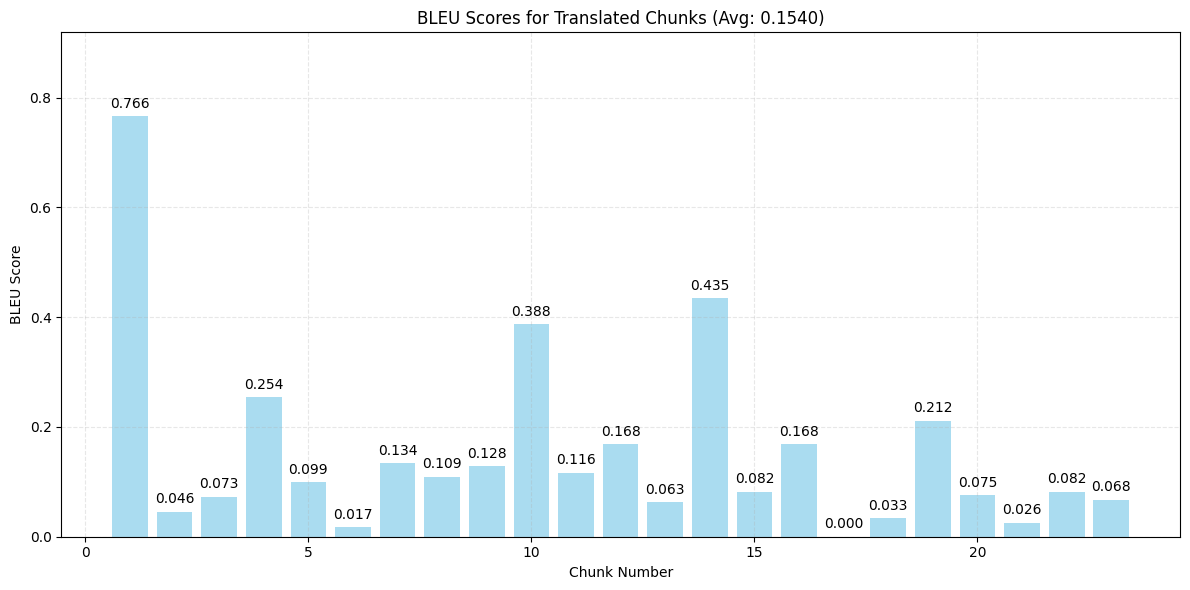

In [ ]:
import matplotlib.pyplot as plt

if bleu_scores:
    plt.figure(figsize=(12, 6))
    bars = plt.bar(range(1, len(bleu_scores)+1), bleu_scores, color="skyblue", alpha=0.7)

    # Add value labels on bars
    for i, bar in enumerate(bars):
        plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
                f'{bleu_scores[i]:.3f}', ha='center', va='bottom')

    plt.xlabel("Chunk Number")
    plt.ylabel("BLEU Score")
    plt.title(f"BLEU Scores for Translated Chunks (Avg: {avg_bleu:.4f})")
    plt.ylim(0, max(bleu_scores) * 1.2 if bleu_scores else 1)
    plt.grid(True, linestyle="--", alpha=0.3)
    plt.tight_layout()
    plt.show()
else:
    print("No data to plot")

### 📑 Sentence-by-Sentence Comparison with BLEU Scores

This section provides a **detailed comparison** for each sentence, showing:

- The original English chunk
- The **model-generated Arabic translation**
- The **reference human translation**
- The **BLEU score** for each pair

---

#### 🎯 Purpose:

- Helps in evaluating the **quality of each translation individually**.
- Useful for manual error analysis and debugging.
- Enables insight into **which sentences scored well or poorly**, and why.

In [ ]:
# Print visual header for the comparison
print("=" * 80)
print("SENTENCE-BY-SENTENCE COMPARISON WITH BLEU SCORES")
print("=" * 80)

# Loop through all sentence chunks and compare each
for i in range(len(sentence_chunks)):
    # Calculate BLEU for this sentence
    ref = [sentence_references[i].split()]         # Tokenized reference as a list of lists
    hyp = translations[i].split()                  # Tokenized model-generated hypothesis
    bleu_score = sentence_bleu(ref, hyp, smoothing_function=smoother)

    # Print detailed output
    print(f"\n--- Sentence {i+1} (BLEU: {bleu_score:.4f}) ---")
    print(f"English:    {sentence_chunks[i]}")
    print(f"Generated:  {translations[i]}")
    print(f"Reference:  {sentence_references[i]}")
    print("-" * 50)


SENTENCE-BY-SENTENCE COMPARISON WITH BLEU SCORES

--- Sentence 1 (BLEU: 0.7660) ---
English:    On March 15th, 2024, Sarah Johnson received an email that would change her life forever.
Generated:  في 15 مارس 2024، تلقت سارة جونسون رسالة إلكترونية من شأنها أن تغير حياتها إلى الأبد.
Reference:  في 15 مارس 2024، تلقت سارة جونسون رسالة بريد إلكتروني من شأنها أن تغير حياتها إلى الأبد.
--------------------------------------------------

--- Sentence 2 (BLEU: 0.0456) ---
English:    The subject line read: "Congratulations!
Generated:  وفيما يلي نص الموضوع: "تهانينا!
Reference:  كان عنوان الرسالة يقول: "تهانينا!
--------------------------------------------------

--- Sentence 3 (BLEU: 0.0729) ---
English:    You've been selected for TechVenture Accelerator 2024."

Sarah couldn't believe her eyes.
Generated:  تم اختيارك لتقنية "التكنلوجيا" Acelerator 2024 "سارة" لم تصدق عينيها
Reference:  لقد تم اختيارك لبرنامج TechVenture Accelerator 2024." لم تصدق سارة عينيها.
--------------------------------

### 🔄 Model Comparison: Different Translation Models

Let’s compare the quality of translations generated by **two different models**:

- **`Helsinki-NLP/opus-mt-en-ar`**: A strong, traditional model trained specifically for English → Arabic translation.
- **`facebook/nllb-200-distilled-600M`**: A multilingual model from Meta’s NLLB project that supports 200+ languages.

---

#### 🧪 Objective:

We'll translate the **same English chunks** using both models and compute **BLEU scores** for each to evaluate performance.

---

#### ⚙️ Next Steps:

1. Load both models and tokenizers.
2. Define a translation function for each.
3. Translate all chunks with both models.
4. Compute BLEU scores and compare results.


In [ ]:
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM

# Load the multilingual model from Meta's NLLB project
nllb_model = AutoModelForSeq2SeqLM.from_pretrained("facebook/nllb-200-distilled-600M")
nllb_tokenizer = AutoTokenizer.from_pretrained("facebook/nllb-200-distilled-600M")


config.json:   0%|          | 0.00/846 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/2.46G [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/2.46G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/189 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/564 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/4.85M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/17.3M [00:00<?, ?B/s]

special_tokens_map.json: 0.00B [00:00, ?B/s]

### 🌍 NLLB Translation Function

This function uses **Meta's NLLB-200 model** (`facebook/nllb-200-distilled-600M`) to translate text from a source language to a target language.

---

#### 🧠 How It Works:

- Sets the **source language** using `src_lang` (e.g., `"eng_Latn"` for English).
- Sets the **target language** using `tgt_lang` (e.g., `"arb_Arab"` for Arabic).
- Uses `forced_bos_token_id` to force decoding into the specified target language.
- Generates the translated output using the model and decodes it into readable text.

---

**Note**: You can translate between any of the 200+ supported languages by changing the codes.


In [ ]:
def translate_nllb(text, src_lang="eng_Latn", tgt_lang="arb_Arab"):
    # Set the source language for the tokenizer
    nllb_tokenizer.src_lang = src_lang

    # Tokenize the input with padding/truncation
    inputs = nllb_tokenizer(
        text,
        return_tensors="pt",
        padding=True,
        truncation=True,
        max_length=512
    )

    # Convert the target language code into a token ID
    tgt_token_id = nllb_tokenizer.convert_tokens_to_ids(tgt_lang)

    # Force decoder to start generation with the target language
    inputs["forced_bos_token_id"] = tgt_token_id

    # Generate translation with a token cap
    outputs = nllb_model.generate(**inputs, max_new_tokens=200)

    # Decode the generated token IDs to readable text
    return nllb_tokenizer.decode(outputs[0], skip_special_tokens=True)


### 🔁 NLLB Translation

Translating all English chunks using the `translate_nllb` function and storing the results in `translations_nllb`.

A progress bar is shown using `tqdm`.


In [ ]:
translations_nllb = [translate_nllb(chunk) for chunk in tqdm(sentence_chunks, desc="NLLB Translation")]

NLLB Translation: 100%|██████████| 23/23 [01:38<00:00,  4.29s/it]


### 📃 NLLB Translation Results

Displaying each original English chunk alongside its Arabic translation generated by the NLLB model.


In [ ]:
# Print all NLLB translations alongside original chunks
print("\n" + "="*50)
print("NLLB TRANSLATION RESULTS")
print("="*50)

for i, (original, translation) in enumerate(zip(sentence_chunks, translations_nllb)):
    print(f"\n--- Chunk {i+1} ---")
    print(f"Original: {original}")
    print(f"Arabic (NLLB): {translation}")
    print("-" * 30)



NLLB TRANSLATION RESULTS

--- Chunk 1 ---
Original: On March 15th, 2024, Sarah Johnson received an email that would change her life forever.
Arabic (NLLB): في 15 مارس 2024، تلقت سارة جونسون رسالة بريد إلكترونيّة ستغير حياتها إلى الأبد.
------------------------------

--- Chunk 2 ---
Original: The subject line read: "Congratulations!
Arabic (NLLB): موضوع الموضوع: "تهنئة!
------------------------------

--- Chunk 3 ---
Original: You've been selected for TechVenture Accelerator 2024."

Sarah couldn't believe her eyes.
Arabic (NLLB): لقد تم اختيارك لـ"تيكفينتور اكسلراتور 2024". لا تصدق سارة عينيها
------------------------------

--- Chunk 4 ---
Original: After 3.5 years of working as a software engineer at DataCorp Inc., earning $95,750 annually, she was finally getting her shot at the big leagues.
Arabic (NLLB): بعد 3.5 سنة من العمل كمحترفة برمجيات في شركة "دايتاكورب" التي تكسب 95 750 دولار سنوياً، كانت تحصل أخيراً على فرصة في الدوري الكبير.
------------------------------

--- Chunk 5 --

### ⚖️ Compare BLEU Scores: Opus-MT vs NLLB

Now we’ll compare a specific sentence across:

- The original English input
- Opus-MT translation
- NLLB translation
- Reference translation

We’ll also analyze token overlap to better understand the lexical similarity between each model’s output and the reference.


In [ ]:
# === SENTENCE COMPARISON ===
print("=== SENTENCE COMPARISON ===")
print("Original English:")
print(sentence_chunks[2])
print("\n" + "="*50)

print("Opus Translation:")
print(translations[2])
print("\n" + "="*50)

print("NLLB Translation:")
print(translations_nllb[2])
print("\n" + "="*50)

print("Reference:")
print(sentence_references[2])
print("\n" + "="*50)

# === TOKEN ANALYSIS ===
print("=== TOKEN ANALYSIS ===")

# Tokenize all sentences by whitespace
opus_tokens = translations[2].split()
nllb_tokens = translations_nllb[2].split()
ref_tokens = sentence_references[2].split()

# Print number of words
print(f"Opus tokens: {len(opus_tokens)} words")
print(f"NLLB tokens: {len(nllb_tokens)} words")
print(f"Reference tokens: {len(ref_tokens)} words")

# Calculate overlapping tokens with reference
opus_matches = set(opus_tokens) & set(ref_tokens)
nllb_matches = set(nllb_tokens) & set(ref_tokens)

# Print overlap count and examples (up to 10 tokens)
print(f"\nOpus matches: {len(opus_matches)} words: {list(opus_matches)[:10]}")
print(f"NLLB matches: {len(nllb_matches)} words: {list(nllb_matches)[:10]}")


=== SENTENCE COMPARISON ===
Original English:
You've been selected for TechVenture Accelerator 2024."

Sarah couldn't believe her eyes.

Opus Translation:
تم اختيارك لتقنية "التكنلوجيا" Acelerator 2024 "سارة" لم تصدق عينيها

NLLB Translation:
لقد تم اختيارك لـ"تيكفينتور اكسلراتور 2024". لا تصدق سارة عينيها

Reference:
لقد تم اختيارك لبرنامج TechVenture Accelerator 2024." لم تصدق سارة عينيها.

=== TOKEN ANALYSIS ===
Opus tokens: 10 words
NLLB tokens: 10 words
Reference tokens: 11 words

Opus matches: 4 words: ['اختيارك', 'تم', 'لم', 'تصدق']
NLLB matches: 5 words: ['اختيارك', 'تم', 'سارة', 'لقد', 'تصدق']


### 📊 BLEU Score & Sentence Comparison: Opus-MT vs NLLB

For each chunk, we show:
- The English source
- Translations from both models
- Reference translation
- BLEU scores for Opus-MT and NLLB


In [ ]:
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction

# Use smoothing to avoid zero BLEU for short sequences
smoother = SmoothingFunction().method4

# Lists to store scores
bleu_opus, bleu_nllb = [], []

# Loop through all references
for i in range(len(sentence_references)):
    ref = [sentence_references[i].split()]         # Human reference tokens
    h1 = translations[i].split()                   # Opus-MT tokens
    h2 = translations_nllb[i].split()              # NLLB tokens

    # Calculate BLEU scores
    score_opus = sentence_bleu(ref, h1, smoothing_function=smoother)
    score_nllb = sentence_bleu(ref, h2, smoothing_function=smoother)

    # Store scores
    bleu_opus.append(score_opus)
    bleu_nllb.append(score_nllb)

    # Display everything per chunk
    print(f"\n=== Chunk {i+1} ===")
    print(f"🔹 English:     {sentence_chunks[i]}")
    print(f"🔷 Opus-MT:     {translations[i]}")
    print(f"🟡 NLLB:        {translations_nllb[i]}")
    print(f"✅ Reference:   {sentence_references[i]}")
    print(f"📈 BLEU (Opus): {score_opus:.4f}")
    print(f"📈 BLEU (NLLB): {score_nllb:.4f}")
    print("-" * 60)

# Print average scores at the end
print(f"\n🔷 Avg Opus-MT BLEU: {sum(bleu_opus)/len(bleu_opus):.4f}")
print(f"🟡 Avg NLLB BLEU:    {sum(bleu_nllb)/len(bleu_nllb):.4f}")



=== Chunk 1 ===
🔹 English:     On March 15th, 2024, Sarah Johnson received an email that would change her life forever.
🔷 Opus-MT:     في 15 مارس 2024، تلقت سارة جونسون رسالة إلكترونية من شأنها أن تغير حياتها إلى الأبد.
🟡 NLLB:        في 15 مارس 2024، تلقت سارة جونسون رسالة بريد إلكترونيّة ستغير حياتها إلى الأبد.
✅ Reference:   في 15 مارس 2024، تلقت سارة جونسون رسالة بريد إلكتروني من شأنها أن تغير حياتها إلى الأبد.
📈 BLEU (Opus): 0.7660
📈 BLEU (NLLB): 0.5648
------------------------------------------------------------

=== Chunk 2 ===
🔹 English:     The subject line read: "Congratulations!
🔷 Opus-MT:     وفيما يلي نص الموضوع: "تهانينا!
🟡 NLLB:        موضوع الموضوع: "تهنئة!
✅ Reference:   كان عنوان الرسالة يقول: "تهانينا!
📈 BLEU (Opus): 0.0456
📈 BLEU (NLLB): 0.0000
------------------------------------------------------------

=== Chunk 3 ===
🔹 English:     You've been selected for TechVenture Accelerator 2024."

Sarah couldn't believe her eyes.
🔷 Opus-MT:     تم اختيارك لتقنية "التكنلو

### 📊 BLEU Score Bar Chart: Opus-MT vs NLLB

This plot shows the BLEU scores for each sentence chunk, comparing **Opus-MT** and **NLLB** side-by-side.


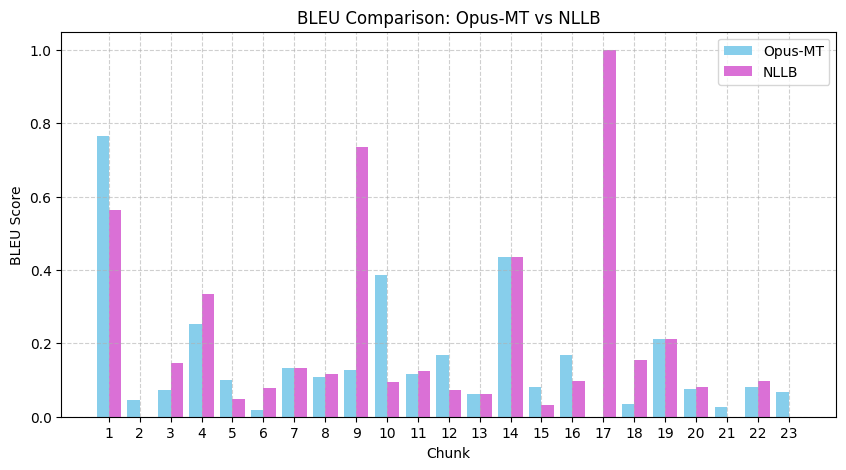

In [ ]:
import matplotlib.pyplot as plt

# X-axis: chunk indices
x = range(1, len(bleu_opus) + 1)

plt.figure(figsize=(10, 5))

# Plot Opus-MT bars shifted left
plt.bar(
    [i - 0.2 for i in x],
    bleu_opus,
    width=0.4,
    label="Opus-MT",
    color="skyblue"
)

# Plot NLLB bars shifted right
plt.bar(
    [i + 0.2 for i in x],
    bleu_nllb,
    width=0.4,
    label="NLLB",
    color="orchid"
)

# X-axis labels and styling
plt.xticks(x)
plt.xlabel("Chunk")
plt.ylabel("BLEU Score")
plt.title("BLEU Comparison: Opus-MT vs NLLB")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.6)

# Show the plot
plt.show()


### 🎵 Bonus Task: Arabic to English Translation (Your Favorite Song)

Let's flip the task! Now it's your turn to translate **from Arabic into English** using your favorite Arabic song lyrics.

---

#### 🎯 Your Mission:

1. **Choose a short Arabic song or verse** that you love (3–5 lines).
2. **Translate it into English** using one of the following:
   - A model (`nllb-200` or `opus-mt-ar-en`)
   - Your own understanding
   - GPT or any tool you like (just note the method used)
3. **Analyze the result**:
   - How accurate is the translation?
   - What meaning or emotion was lost or kept?
   - Which model did better (if you tried more than one)?

---



Enjoy translating — and bring your favorite music to life in a new language! 🎤🌍


In [ ]:
# Your Arabic song lyrics (multi-line string)
arabic_lyrics = """
تَعَلَّقَ قَلبي طَفلَةً عَرَبِيَّةً
تَنَعمُ في الدِّيبَاجِ والحَلى والحُلَل
لَهَا مُقلَةٌ لَو أَنَّهَا نَظَرَت بِهَا
إِلى رَاهِبٍ قَد صَامَ لِلّهِ وابتَهَل
لَأَصبَحَ مَفتُوناً مُعَنَّى بِحُبِّهَا
كَأَن لَم يَصُم لِلّهِ يَوماً ولَم يُصَل
"""

# Translate using existing function
english_translation = translate_nllb(arabic_lyrics, src_lang="arb_Arab", tgt_lang="eng_Latn")

# Display result
print("🎶 Original Arabic Lyrics:")
print(arabic_lyrics.strip())
print("\n Translated English:")
print(english_translation)


🎶 Original Arabic Lyrics:
تَعَلَّقَ قَلبي طَفلَةً عَرَبِيَّةً
تَنَعمُ في الدِّيبَاجِ والحَلى والحُلَل
لَهَا مُقلَةٌ لَو أَنَّهَا نَظَرَت بِهَا
إِلى رَاهِبٍ قَد صَامَ لِلّهِ وابتَهَل
لَأَصبَحَ مَفتُوناً مُعَنَّى بِحُبِّهَا
كَأَن لَم يَصُم لِلّهِ يَوماً ولَم يُصَل

 Translated English:
My heart hung on an Arab child who was soothing in dipping and sweet and sweet her heart was so worried if she looked at her like a monk who had fasted to God and neglected to become a lover of her as if he had never fasted to God and never prayed.


### 🧭 Next Steps: Choose Your Improvement Track

Now that you've completed the base translation notebook, here are **5 optional learning tracks** to help you improve translation quality and deepen your understanding.

Choose one (or more) to explore further — each has clear goals and outcomes.

---

#### 📏 Track 1: Context-Aware Chunking
**Goal:** Improve translation quality by grouping related sentences.

**What you'll do:**
- Merge related chunks into paragraphs before translating.
- Compare BLEU scores before vs. after.

**What to expect:**
✅ Better handling of pronouns, idioms, and flow  
📉 Slightly slower inference, but more coherent output

---

#### 🎛️ Track 2: Decoding Parameter Tuning
**Goal:** Find the best decoding settings for your model.

**What you'll do:**
- Experiment with `top_k`, `top_p`, `temperature`, and `num_beams`.
- Evaluate results using BLEU and your own judgment.

**Suggested ranges:**
- `top_k`      | 30–60
- `top_p`      | 0.85–0.95
- `temperature`| 0.7–1.0
- `num_beams`  | 4–6

**What to expect:**
🎨 More diverse or controlled outputs  
🧠 Better understanding of sampling vs. beam search

---

#### 🧪 Track 3: Metric Upgrade
**Goal:** Evaluate translations using more reliable metrics.

**What you'll do:**
- Use `sacrebleu`, `chrF`, or `BERTScore`.
- Compare how each metric ranks your translations.

**What to expect:**
✅ Insights into how BLEU can be misleading  
📈 More correlation with human judgment (especially for Arabic)

---

#### 🤖 Track 4: Try Bigger or Specialized Models
**Goal:** Improve quality using larger or better-suited models.

**What you'll do:**
- Replace your current model with one of the following:
  - `facebook/nllb-200-1.3B`
  - `facebook/m2m100_1.2B`
- OR test the same input using commercial APIs (DeepL, Google Translate, Azure).

**What to expect:**
🚀 Higher BLEU scores  
💻 Increased memory and runtime requirements  
💡 Trade-offs between open-source and commercial solutions

---

#### ✍️ Track 5: Post-Editing and Retraining
**Goal:** Learn how human feedback fits into machine translation workflows.

**What you'll do:**
- Manually correct the lowest-scoring translations.
- Optionally fine-tune a model on the improved samples.

**What to expect:**
🛠️ Clear quality gains with minimal effort  
🔁 Understand real-world translation workflows  
📚 Learn how feedback improves models

---

Choose a track based on your interests and curiosity — and don’t be afraid to mix and match! 🚀
